## Import Necessary Libraries and Frameworks:

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

from collections import Counter

import re, string, ast, json
import matplotlib.pyplot as plt

from nltk.tokenize.casual import TweetTokenizer

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import arabic_reshaper
from bidi.algorithm import get_display

from openpyxl import load_workbook

In [5]:
path='../data/'
dataset_name = 'insurance'

# Preprocess

In [6]:
def preprocess(text):
    stop_words = list()
    with open(path+'farsi_stopwords.txt',encoding='utf-8') as f:
        for line in f:
            stop_words.append(line.strip())
    exclusions = ["ir","#ff", "ff", "rt","RT", "FF","\u200c","\n","'s","n't","'re","'m",'#','@','&','?','.','+','-','*','/','’','...','…','‘','“','”','–','؟','،','.','"',';','!',':','%','.',',']
    stop_words.extend(exclusions)

    junk_chars_regex = r'[^a-zA-Z\u0621-\u06CC\u0698\u067E\u0686\u06AF \u200c]'
    url_regex = r"""((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"""
    RFC_5322_COMPLIANT_EMAIL_REGEX = r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
    compile_patterns = lambda patterns: [(re.compile(pattern), repl) for pattern, repl in patterns]

    remove_url = (url_regex, ' ')
    remove_email = (RFC_5322_COMPLIANT_EMAIL_REGEX, ' ')
    remove_junk_characters = (junk_chars_regex, ' ')
    compiled_patterns_before = compile_patterns([remove_url, remove_email])
    compiled_patterns_after = compile_patterns([remove_junk_characters])
    # html parser
    text = text.lower()
    for pattern, repl in compiled_patterns_before:
        text = pattern.sub(repl, text)
    text = re.sub(r'[\u200c\s]*\s[\s\u200c]*', ' ', text)
    text = re.sub(r'[\u200c]+', '\u200c', text)

    for pattern, repl in compiled_patterns_after:
        text = pattern.sub(repl, text)

    tokenized_words = tokenizer.tokenize(text)


    tokenized_words = [word for word in tokenized_words if word not in stop_words]


    return tokenized_words

def remove_emoji(text):
    junk_chars_regex = r'[^a-zA-Z_\u0621-\u06CC\u0698\u067E\u0686\u06AF \u200c]'
    compile_patterns = lambda patterns: [(re.compile(pattern), repl) for pattern, repl in patterns]
    remove_junk_characters = (junk_chars_regex, ' ')
    compiled_patterns_after = compile_patterns([remove_junk_characters])
    for pattern, repl in compiled_patterns_after:
        text = pattern.sub(repl, text)
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def char_notmalizer(text):
    """I broked down this process to 5 parts because of `Maximum parse depth exceeded` """
    
    text = text.replace('۰', '0').replace('۱', '1').replace('۲', '2').\
    replace('۳', '3').replace('۴', '4').replace('۵', '5').replace('۶', '6').\
    replace('۷', '7').replace('۸', '8').replace('۹', '9').replace('٠', '0').\
    replace('١', '1').replace('٢', '2').replace('٣', '3').replace('٤', '4').\
    replace('٥', '5').replace('٦', '6').replace('٧', '7').replace('٨', '8').\
    replace('٩', '9').replace('۰', '0').replace('۱', '1').replace('۲', '2').\
    replace('۳', '3').replace('۴', '4').replace('۵', '5').replace('۶', '6').\
    replace('۷', '7').replace('۸', '8').replace('۹', '9').replace('ء', '').\
    replace('ؤ', 'و').replace('إ', 'ا').replace('ٲ', 'ا').replace('أ', 'ا').\
    replace('ي', 'ی').replace('ئ', 'ی').replace('ك', 'ک').replace('ى', 'ا').\
    replace('️', '').replace('ُ', '').replace('َ', '').replace('ِ', '').replace('ـ', '')
    
    text = text.replace('\u200c', ' ').replace('\u200f', ' ').replace('ة', 'ه').replace('ە', 'ه').\
    replace('ۀ', 'ه').replace('ﺍ', 'ا').\
    replace('ﺭ', 'ر').replace('ﻣ', 'م').replace('ﺩ', 'د').replace('ﺪ', 'د').replace('ﻭ', 'و').\
    replace('ﺮ', 'ر').replace('ﻧ', 'ن').replace('ھ', 'ه').replace('ﻪ', 'ه').replace('ڪ', 'ک').\
    replace('ﺳ', 'س').replace('ﻮ', 'و').replace('ﯾ', 'ی').replace('ﮔ', 'گ').replace('ﺖ', 'ت').\
    replace('ﺧ', 'خ').replace('ﯽ', 'ی').replace('ﻦ', 'ن').replace('ﻨ', 'ن').replace('ﺘ', 'ت').\
    replace('ﮐ', 'ک').replace('ﻥ', 'ن').replace('ﯿ', 'ی').replace('ﺑ', 'ب').replace('ﻬ', 'ه').\
    replace('ﻫ', 'ه').replace('ﺷ', 'ش').replace('ﭘ', 'پ').replace('ﺸ', 'ش').replace('ﻤ', 'م').\
    replace('ﺰ', 'ز').replace('ﺗ', 'ت').replace('ﯼ', 'ی').replace('ﮏ', 'ک').replace('ﻢ', 'م').\
    replace('ﻖ', 'ق').replace('ﺁ', 'آ').replace('ﻡ', 'م').replace('ﻓ', 'ف').replace('ﻗ', 'ق').\
    replace('ﺒ', 'ب').replace('ﻋ', '').replace('ﺣ', 'ح').replace('ﮑ', 'ک').replace('ﻴ', 'ی').\
    replace('ﻔ', 'ف').replace('ﺟ', 'ج').replace('ﮕ', 'گ').replace('ﻛ', 'ک').replace('ﭼ', 'چ').\
    replace('ٱ', '').replace('ٖ', '').replace('ﻝ', 'ل').replace('ﻞ', 'ل').replace('ﺵ', 'ش').\
    replace('ﻌ', 'ع').replace('ﻳ', 'ی').replace('ﺨ', 'خ').replace('ے', 'ی').replace('ﮊ', 'ژ').\
    replace('ﺻ', 'ص').replace('ٓ', '').replace('ۂ', 'ه').replace('ﻃ', 'ط').replace('ﺦ', 'خ').\
    replace('ﻻ', 'لا').replace('ﻏ', 'غ').replace('ﺐ', 'ب').replace('ﺕ', 'ت').replace('ﻼ', 'لا').\
    replace('ﻰ', 'ا').replace('ﻲ', 'ی').replace('ﻘ', 'ق').replace('ﺼ', 'ص').replace('ﺲ', 'س').\
    replace('ﺏ', 'ب').replace('ﺶ', 'ش').replace('ﺠ', 'ج').replace('ہ', 'ه').replace('ـغ', 'غ').\
    replace('ﻩ', 'ه').replace('تـ', 'ت').replace('ـذ', 'ذ').replace('ﺯ', 'ز').replace('ـظ', 'ظ')
    
    text=text.replace('غـ', 'غ').replace('ﻄ', 'ط').replace('ﻠ', 'ل').replace('ﺴ', 'س').replace('﮼', '').\
    replace('ﻟ', 'ل').replace('﷽', 'بسم الله الرحمن الرحیم').replace('ٍ', '').replace('ٔ', '').\
    replace('ً', '').replace('ّ', '').replace('ْ', '').replace('ٰ', '').replace('ٌ', '').\
    replace('ı', 'i').replace('?', '؟').replace('❗', '!').replace('🇨', 'C').replace('🇪', 'E').\
    replace('🇵', 'P').replace('🇾', 'Y').replace('🇦', 'A').replace('🇺', 'U').replace('🇮', 'I').\
    replace('🇸', 'S').replace('🇷', 'R').replace('‼', '!!').replace('ﺎ', 'L').replace('🇻', 'V').\
    replace('🇫', 'F').replace('🇬', 'G').replace('🇳', 'N').replace('𝑑', 'd').replace('𝑜', 'o').\
    replace('🇹', 'T').replace('𝒆', 'e').replace('𝑎', 'a').replace('𝑏', 'b').replace('🇧', 'B').\
    replace('𝒐', 'o').replace('𝒂', 'a').replace('𝑛', 'n').replace('𝑔', 'g').replace('🇰', 'k').\
    replace('🇱', 'L').replace('𝒓', 'r').replace('𝑣', 'v').replace('🇩', 'D').replace('🇯', 'J').\
    replace('🇲', 'M').replace('–', '-').replace('—', '-').replace('‐', '-').replace('−', '-')
    
    text = text.replace('︎', '').replace('ؑ', '').replace('ﺿ', 'ض').replace('ﺜ', 'ث').\
    replace('ﻇ', 'ظ').replace('ۍ', 'ی').\
    replace('ﮒ', 'گ').replace('ﻕ', 'ق').replace('ﭙ', 'پ').replace('ۆ', 'ق').replace('ﭽ', 'چ').\
    replace('ﺤ', 'ح').replace('ﻐ', 'غ').replace('ٸ', 'ی').replace('ﺛ', 'ث').replace('ﻀ', 'ض').\
    replace('ﻈ', 'ظ').replace('ﺞ', 'ج').replace('ﮎ', 'ک').replace('ﮓ', 'گ').replace('ۊ', 'و').\
    replace('ڕ', 'ر').replace('ﻍ', 'غ').replace('ێ', 'ی').replace('ﺥ', 'خ').replace('ﻆ', 'ظ').\
    replace('ﻉ', 'ع').replace('ځ', 'ح').replace('ﺢ', 'ح').replace('ﺽ', 'ض').replace('ᴥ', 'ع').\
    replace('ﻚ', 'ک').replace('ﻊ', 'ع').replace('ۏ', 'و').replace('ﺱ', 'س').replace('ݓ', 'ب').\
    replace('ٺ', 'ت').replace('ﻱ', 'ی').replace('ﺋ', 'ی').replace('ﺹ', 'ص').replace('ﻒ', 'ف').\
    replace('ﻑ', 'ف').replace('ٙ', '').replace('ٕ', 'ا').replace('ﻯ', 'ی').replace('ﭻ', 'چ').\
    replace('ﻜ', 'ک').replace('ﺬ', 'ذ').replace('ٴ', '').replace('ۚ', '').replace('ګ', 'ک').\
    replace('ۡ', '').replace('ٚ', '').replace('ڵ', 'ل').replace('ۖ', '').replace('݊', '').replace('٘', '').\
    replace('ۤ', '').replace('ۓ', 'ی').replace('ڱ', 'گ').replace('ٮ', 'ب').replace('ﺆ', 'و').\
    replace('ڟ', 'ط').replace('ڴ', 'گ').replace('ﺚ', 'ث').replace('ﻁ', 'ط').replace('ﺝ', 'ج').\
    replace('ﻵ', 'لا').replace('ݕ', 'ب').replace('ﻂ', 'ط').replace('ڔ', 'ر').replace('ښ', 'س')
    
    text = text.replace('ۼ', 'غ').replace('ٶ', 'و').replace('ۇ', 'و').replace('ﻎ', 'غ').replace('ۭ', '').\
    replace('ﷲ', 'الله').replace('ؐ', 'صلی الله').replace('﷼', 'ریال').replace('🇴', 'O').\
    replace('🇭', 'H').replace('🇿', 'Z').replace('𝖊', 'e').replace('𝒘', 'w').replace('𝓬', 'c').\
    replace('𝓘', 'I').replace('𝒏', 'n').replace('𝒙', 'x').replace('𝒅', 'd').replace('ɴ', 'N').\
    replace('𝓸', 'o').replace('𝘀', 's').replace('𝗮', 'a').replace('𝓲', 'i').replace('𝓷', 'n').\
    replace('𝓪', 'a').replace('𝗶', 'i').replace('ᴍ', 'M').replace('ܳ', '').replace('ℓ', 'l').\
    replace('𝗻', 'n').replace('𝗰', 'c').replace('ᴜ', 'U').replace('ʏ', 'Y').replace('ʟ', 'L').\
    replace('ᴋ', 'K').replace('𝕨', 'w').replace('𝒶', 'a').replace('𝗱', 'd').replace('𝗹', 'l').\
    replace('𝗳', 'f').replace('𝒔', 's').replace('𝒖', 'u').replace('𝑴', 'M').replace('𝑹', 'R').\
    replace('𝑒', 'e').replace('𝓟', 'P').replace('𝘁', 't').replace('𝗲', 'e').replace('𝖆', 'a').\
    replace('𝖈', 'c').replace('𝖓', 'n').replace('𝖒', 'm').replace('𝖝', 'x').replace('𝓮', 'e').\
    replace('𝓼', 's').replace('𝓵', 'l').replace('ʜ', 'H').replace('ɪ', 'I').replace('ᴀ', 'A').\
    replace('𝓽', 't').replace('〰', '-')
    return text

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def farsi(text):
    return get_display(arabic_reshaper.reshape(text))


In [81]:
df=pd.read_csv(path+f'dataset_{dataset_name}.csv')


df['text'] = df['text'].fillna('')
df['quote_text'] = df['quote_text'].fillna('')
df.loc[df['retweet_text'].notna(),'text'] = df['retweet_text']
df.loc[df['quote_text']!='','text'] = df.progress_apply(lambda ind: ind['quote_text']+ ind['text'] if ind['quote_text']!=None else ind['text'],axis=1)
print(df['quote_text'][153])


هر وقت فکر میکنم برای انجام همه نوع مشاوره دیگه آماده ام باز سوپرایز میشم. مددجوم اومد گفت که فکر کنه اچ آی وی مثبت هست. نوزده سالشه و خیلی بهم ریخته. تا حالا مشاوره نداده بودم در این رابطه. فقط شانس آوردم که همین دو هفته پیش از اداره بهداشت دودنفر اومدن و یکم اطلاعات دادن بهمون


In [88]:
df.iloc[33559]

id                                                                       3280682
status_id                                                    1642219070538891266
created_at                                            2023-04-01 17:35:12.000000
text                           @itsentman آره هست ولی حداقل برای تهران و اطرا...
reply_count                                                                  NaN
seen_date                                             2023-04-02 20:31:10.000000
is_quote                                                                       0
is_retweet                                                                     0
quote_count                                                                  NaN
retweet_count                                                                  0
like_count                                                                     1
total                                                                          1
lang                        

In [65]:
#Topic Modelling:

df=pd.read_csv(path+f'dataset_{dataset_name}.csv')

df['text'] = df['text'].fillna('')
df['quote_text'] = df['quote_text'].fillna('')
df.loc[df['retweet_text'].notna(),'text'] = df['retweet_text']
df.loc[df['quote_text']!='','text'] = df.progress_apply(lambda ind: ind['quote_text']+ ind['text'] if ind['quote_text']!=None else ind['text'],axis=1)


print(df.shape)
df=df[df['lang']=='fa']
print(df.shape)

tokenizer = TweetTokenizer()

df['text']=df['text'].fillna('')
df=df.drop_duplicates(subset=['text'])
print(df.shape)

df['pre_text'] = [str(i).lower() for i in df['text']]
df['pre_text'] = df['pre_text'].apply(lambda x:char_notmalizer(x))
print('lower case and normalized the characters.')
df['pre_text']=df['pre_text'].str.replace('\d+', '')
df['pre_text'] = df['pre_text'].progress_apply(lambda x: re.sub('@[\w\-]+','',str(x)),)
df['pre_text_noHAshtag'] = df['pre_text'].progress_apply(lambda x: re.sub('#[\w\-]+','',str(x)))  #delete hashtags??!


print('delete hashtags and mentions')

df['pre_text']=df['pre_text'].progress_apply(lambda x:re.sub(r"http\S+", "", x))
df['pre_text_noHAshtag']=df['pre_text_noHAshtag'].progress_apply(lambda x:re.sub(r"http\S+", "", x))
print('delete links')

df['pre_text_wHashtag']=df['pre_text'].progress_apply(lambda x:x.replace('_','') )
df['pre_text']=df['pre_text'].progress_apply(lambda x:remove_emoji(x) )
df['pre_text_noHAshtag']=df['pre_text_noHAshtag'].progress_apply(lambda x:remove_emoji(x) )
df['pre_text_wHashtag']=df['pre_text_wHashtag'].progress_apply(lambda x:remove_emoji(x) )
print('removed emojies')
df['pre_text']=df['pre_text'].progress_apply(lambda x:preprocess(x))
df['pre_text_noHAshtag']=df['pre_text_noHAshtag'].progress_apply(lambda x:preprocess(x))
df['pre_text_wHashtag']=df['pre_text_wHashtag'].progress_apply(lambda x:preprocess(x))
print('preprocess the text')
df['pre_text']=df['pre_text'].progress_apply(lambda x:' '.join([word for word in x]))
df['pre_text_noHAshtag']=df['pre_text_noHAshtag'].progress_apply(lambda x:' '.join([word for word in x]))
df['pre_text_wHashtag']=df['pre_text_wHashtag'].progress_apply(lambda x:' '.join([word for word in x]))
print('join tokens')
df.to_csv(path+f'df_pre_with_hashtags_{dataset_name}.csv')


/var/folders/nb/d3bw47gn6qj6n_bg2n_g5y140000gn/T/ipykernel_19538/2319411161.py:3: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path+f'dataset_{dataset_name}.csv')
100%|████████████████████████████████| 128491/128491 [00:01<00:00, 87232.54it/s]


(128491, 55)
(102847, 55)
(27880, 55)
lower case and normalized the characters.


100%|█████████████████████████████████| 27880/27880 [00:00<00:00, 354063.30it/s]


delete hashtags and mentions


100%|█████████████████████████████████| 27880/27880 [00:00<00:00, 368577.77it/s]


delete links


100%|██████████████████████████████████| 27880/27880 [00:00<00:00, 96482.36it/s]


removed emojies


100%|████████████████████████████████████| 27880/27880 [00:52<00:00, 529.66it/s]


preprocess the text


100%|█████████████████████████████████| 27880/27880 [00:00<00:00, 415442.86it/s]


join tokens


# Topic Modeling

In [66]:
def choos_best_LDA(df, topic_name, text_column ='pre_text' , range_list = range(3,11,2)):
    
    t_topics = []
    t_score = []
    t_score1 = []
    t_perplex = []
    LDA_models=[]
    
    df=df.dropna(subset=[text_column])
    tokenizer = TweetTokenizer()
    df['tok']=df[text_column].apply(lambda x: tokenizer.tokenize(x))
    dct= Dictionary(df['tok'].tolist())
    dct.filter_extremes(no_above=.8,no_below=10)
    docs=df['tok'].tolist()
    corpus = [dct.doc2bow(doc) for doc in docs]
    
    topics =[] 
    score =[] 
    score1 =[] 
    perplex =[] 

    for i in tqdm(range_list):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dct,
                                            iterations=10,num_topics=i,
                                            alpha='auto',eta=0.51,
                                            passes=10,random_state=100)
        
        LDA_models.append({'topic':topic_name,'no-topic':i,'model':lda_model})
        
        cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dct, coherence='u_mass')
        topics.append(i)
        score.append(cm.get_coherence())
        perplex.append(lda_model.log_perplexity(corpus))

#---

    fig, axs = plt.subplots(2)
    fig.suptitle(farsi(f'نتایج LDA {topic_name}'))

    axs[0].plot(topics, score, label='Coherence')
    axs[1].plot(topics, perplex)

    axs[0].set_title('Coherence')
    axs[1].set_title('perplexity')
    for ax in axs.flat:
        ax.label_outer()
    axs[1].set(xlabel=farsi('تعداد موضوع'))
    plt.legend()
    plt.show()
    return LDA_models


In [67]:
dataset=[pd.read_csv(path+f'df_pre_with_hashtags_media.csv'),
         pd.read_csv(path+f'df_pre_with_hashtags_people.csv')]
dataset=pd.concat(dataset,ignore_index=True)

In [68]:
dataset.drop_duplicates(subset='pre_text',ignore_index=True,inplace=True)
dataset

,Unnamed: 0,tweet_id,topic,sub_topic,processed_text,datetime,text,reply_count,retweet_count,like_count,username,lang,media,hashtags,pre_text,pre_text_noHAshtag,pre_text_wHashtag
0,0,1.489876e+18,economics,market,عرضه سیب زمین قیمت تومان میادین تهران عرضه گست...,2022-02-05 08:16:34+00:00,عرضه سیب زمینی با قیمت ۱۰ هزار تومان در میادین...,0.0,0.0,6.0,khabaronlinee,fa,[Photo(previewUrl='https://pbs.twimg.com/media...,['سیب\u200cزمینی'],عرضه سیب زمینی قیمت تومان میادین تهران عرضه گس...,عرضه سیب زمینی قیمت تومان میادین تهران عرضه گس...,عرضه سیب زمینی قیمت تومان میادین تهران عرضه گس...
1,1,1.489867e+18,economics,market,یارانه تومان افزایش یافت#یاب نایب رییس کمیسیون...,2022-02-05 07:43:51+00:00,یارانه ۴۵ هزار تومانی افزایش نمی‌یابد\n\nنایب ...,2.0,3.0,8.0,khabaronlinee,fa,NaN,['یارانه'],یارانه تومانی افزایش نایب رییس کمیسیون برنامه ...,یارانه تومانی افزایش نایب رییس کمیسیون برنامه ...,یارانه تومانی افزایش نایب رییس کمیسیون برنامه ...
2,2,1.489820e+18,economics,market,اقای صدیق دانست#دان سیبزمینی ماه عمر دولت فعلی...,2022-02-05 04:34:48+00:00,آقای صدیقی! می دانید #سیب_زمینی در ۶ ماه عمر د...,3.0,2.0,13.0,khabaronlinee,fa,NaN,['سیب_زمینی'],صدیقی دانید سیب زمینی ماه عمر دولت فعلی تومان ...,صدیقی دانید ماه عمر دولت فعلی تومان روزنامه جم...,صدیقی دانید سیبزمینی ماه عمر دولت فعلی تومان ر...
3,3,1.489687e+18,economics,market,مهاجم پرسپولیس مجید صدر مدیرعامل پرسپولیس میهم...,2022-02-04 19:45:17+00:00,۴۰ میلیارد برای مهاجم پرسپولیسی؟\n\nمجید صدری ...,0.0,0.0,8.0,khabaronlinee,fa,[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,مهاجم پرسپولیسی مجید صدری مدیرعامل پرسپولیس می...,مهاجم پرسپولیسی مجید صدری مدیرعامل پرسپولیس می...,مهاجم پرسپولیسی مجید صدری مدیرعامل پرسپولیس می...
4,4,1.489652e+18,economics,market,پنتاگون وزارت خارجه امریکا فروش احتمال سلاح کش...,2022-02-04 17:28:42+00:00,پنتاگون اعلام کرد، وزارت خارجه آمریکا فروش احت...,0.0,1.0,10.0,khabaronlinee,fa,NaN,NaN,پنتاگون وزارت خارجه آمریکا فروش احتمالی سلاح ک...,پنتاگون وزارت خارجه آمریکا فروش احتمالی سلاح ک...,پنتاگون وزارت خارجه آمریکا فروش احتمالی سلاح ک...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255778,49993,1.483363e+18,sport,NaN,مهدی_شریفی لیگ هجدهم نیم فصل حمیدرضا گرشاسبی پ...,2022-01-18 08:58:51+00:00,#مهدی_شریفی که لیگ هجدهم برای یک نیم فصل و در ...,0.0,0.0,1.0,aghrabejarrare,fa,NaN,"['مهدی_شریفی', 'پرسپولیس', 'پرسپوليس']",مهدی شریفی لیگ هجدهم نیم فصل حمیدرضا گرشاسبی پ...,لیگ هجدهم نیم فصل حمیدرضا گرشاسبی قرارداد بابت...,مهدیشریفی لیگ هجدهم نیم فصل حمیدرضا گرشاسبی پر...
255779,49994,1.479905e+18,sport,NaN,برگشتن وینیسیوس ترکیب جذابه وازکز میبینی ریال_...,2022-01-08 19:55:24+00:00,برگشتن وینیسیوس به ترکیب خیلی جذابه تا اینکه و...,0.0,0.0,3.0,AmirEmbrose,fa,NaN,['رئال_مادرید'],برگشتن وینیسیوس ترکیب جذابه وازکز میبینی ریال ...,برگشتن وینیسیوس ترکیب جذابه وازکز میبینی,برگشتن وینیسیوس ترکیب جذابه وازکز میبینی ریالم...
255780,49996,1.486771e+18,sport,NaN,تبریک تبریک ایران تبریک همه‌ی هواداران خاک عزی...,2022-01-27 18:39:54+00:00,تبریک به مردم، تبریک به #ایران، تبریک به همه‌ی...,0.0,3.0,21.0,sadr_mohsen,fa,[Photo(previewUrl='https://pbs.twimg.com/media...,"['ایران', 'تیم_ملی', 'جام_جهانی']",تبریک تبریک ایران تبریک هواداران خاک عزیز تیم ...,تبریک تبریک تبریک هواداران خاک عزیز,تبریک تبریک ایران تبریک هواداران خاک عزیز تیمم...
255781,49997,1.487147e+18,sport,NaN,یاور مومن وقت نبودن سیاست شهرت طلب سیری ناپذیر...,2022-01-28 19:32:35+00:00,یاور همیشه مومن، چه وقت نبودن بود بین این همه ...,0.0,1.0,13.0,bahar39886432,fa,[Photo(previewUrl='https://pbs.twimg.com/media...,['پرسپولیس'],یاور مومن وقت نبودن سیاست شهرت طلب سیری ناپذیر...,یاور مومن وقت نبودن سیاست شهرت طلب سیری ناپذیر...,یاور مومن وقت نبودن سیاست شهرت طلب سیری ناپذیر...


In [69]:
df['topic'] = 'insurance'
dataset= df.copy(deep=True)
dataset.drop_duplicates(subset='pre_text',ignore_index=True,inplace=True)
print(Counter(dataset.topic))

Counter({'insurance': 26295})


Counter({'insurance': 26295})


100%|█████████████████████████████████████████████| 7/7 [04:14<00:00, 36.40s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


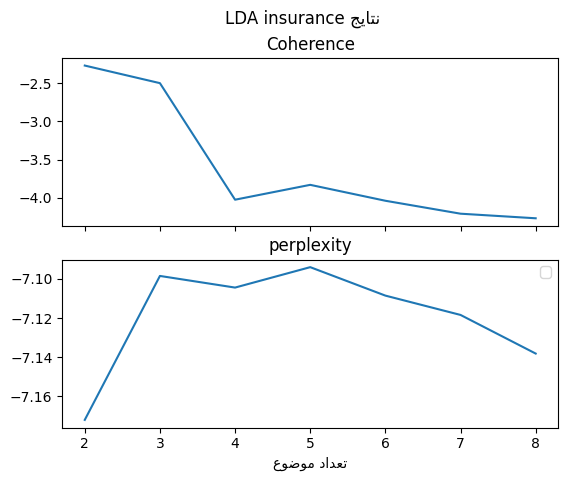

In [70]:

print(Counter(dataset.topic))
LDA_models=[]
topics = ['insurance']
for t_name in topics:
    df = dataset[dataset.topic==t_name]
    ldas = choos_best_LDA(df,t_name,range_list=range(2,9))
    LDA_models+=ldas


In [71]:
dataset['tok']=dataset['pre_text'].apply(lambda x: tokenizer.tokenize(x))


for model_info in tqdm(LDA_models, position=0, leave=True):
    num_topics=model_info['no-topic']
    topic_name = model_info['topic']
    lda_model =  model_info['model']
    
    df = dataset[dataset.topic==topic_name]
    dct= Dictionary(df['tok'].tolist())
    dct.filter_extremes(no_above=.8,no_below=10)
    topic_words=[]
    
    for i in range(num_topics):
        tt = lda_model.get_topic_terms(i,40)
        topic_words.append([dct[pair[0]] for pair in tt])
    df_topwords=pd.DataFrame(topic_words)
    df_topwords=df_topwords.T
    
    P = f'{path}topwords3_{topic_name}.xlsx'
    try:
        with pd.ExcelWriter(P, engine='openpyxl', mode='a') as writer:  
            df_topwords.to_excel(writer, sheet_name=f'T_{num_topics}')
#         print(topic_name,f' T_{num_topics}')
    except Exception as e: 
#         print(e)
        print('create_file path:',P)
        with pd.ExcelWriter(P) as writer:  
            df_topwords.to_excel(writer, sheet_name=f'T_{num_topics}')
            



 14%|██████▍                                      | 1/7 [00:00<00:05,  1.17it/s]

create_file path: ../data/topwords3_insurance.xlsx


100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


In [76]:
for model_info in tqdm(LDA_models, position=0, leave=True):
    num_topics=model_info['no-topic']
    topic_name = model_info['topic']
    lda_model =  model_info['model']
    
    df = dataset[dataset.topic==topic_name]
    df = df.sample(n=4000,replace=False,random_state=42)
    docs=df['tok'].tolist()
    
    dct= Dictionary(df['tok'].tolist())
    dct.filter_extremes(no_above=.8,no_below=10)
    
    corpus = [dct.doc2bow(doc) for doc in docs]
    
    m=[]
    for row in lda_model[corpus]:
        row_topic = {x[0]:x[1] for x in row}
        k=max(row_topic, key=row_topic.get)
        m.append(max(row_topic, key=row_topic.get))

    topic_df = pd.DataFrame(m,columns=['pred_topic']).fillna(0)
    sent_topics_df = pd.concat([df.reset_index(drop=True),topic_df], axis=1)
    sent_topics_df = sent_topics_df[['text','pred_topic','id', 'status_id', 'created_at',  'reply_count', 'seen_date',
       'is_quote', 'is_retweet', 'quote_count', 'retweet_count', 'like_count',
       'total', 'lang', 'user_id_id', 'screen_name', 'url_expanded_url',
       'urls_expanded_url', 'in_reply_to_user_id', 'retweet_status_id',
       'retweet_created_at', 'retweet_text', 'retweet_reply_count',
       'retweet_quote_count', 'retweet_retweet_count', 'retweet_like_count',
       'retweet_lang', 'retweet_user_id', 'retweet_screen_name',
       'retweet_total', 'retweet_url_expanded_url',
       'retweet_urls_expanded_url', 'retweet_in_reply_to_user_id',
       'quote_status_id', 'quote_created_at', 'quote_text', 'quote_name',
       'quote_reply_count', 'quote_quote_count', 'quote_retweet_count',
       'quote_like_count', 'quote_lang', 'quote_user_id', 'quote_screen_name',
       'quote_urls_expanded_url', 'quote_url_expanded_url',
       'quote_in_reply_to_user_id', 'sentiment', 'related_keyword_id',
       'created_at_timestamp', 'is_automobile', 'is_other_policy', 'is_person',
       'is_relevant', 'is_subject', 'stance', 'pre_text', 'pre_text_noHAshtag',
       'pre_text_wHashtag', 'topic', 'tok']]
    sent_topics_df = sent_topics_df.groupby('pred_topic').head(50)
    P = f'{path}labeled_sample3_{topic_name}.xlsx'
    try:
        with pd.ExcelWriter(P, engine='openpyxl', mode='a') as writer:  
            sent_topics_df.to_excel(writer, sheet_name=f'T_{num_topics}')
#         print(topic_name,f' T_{num_topics}')
    except Exception as e: 
#         print(e)
        print('create_file path:',P)
        with pd.ExcelWriter(P) as writer:  
            sent_topics_df.to_excel(writer, sheet_name=f'T_{num_topics}')


 14%|██████▍                                      | 1/7 [00:03<00:18,  3.04s/it]

create_file path: ../data/labeled_sample3_insurance.xlsx


100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.03s/it]


In [73]:
dataset.to_csv(f'{path}total_preprocessed_data{topic_name}.csv',index=False)

# Labeled

In [64]:
df = pd.read_csv(f"{path}/label_sample_topicLDA6_people_U.csv")
print(Counter(df.label))
df = pd.read_csv(f"{path}/label_sample_topicLDA6_media_U.csv")
print(Counter(df.label))

#  - label_sample_topicLDA6_media_U

Counter({nan: 139, 'health': 41, 'social': 31, 'sport': 31, 'poem': 22, 'economics': 22, 'art': 14})
Counter({nan: 154, 'politics': 31, 'health': 28, 'art': 25, 'sport': 23, 'economics': 20, 'social': 19})
